Class distribution after augmentation: Counter({28: 446, 54: 324, 3: 260, 5: 194, 55: 162, 35: 156, 7: 152, 30: 150, 16: 142, 11: 138, 17: 130, 14: 128, 26: 126, 0: 118, 56: 110, 1: 100, 2: 100, 4: 100, 6: 100, 8: 100, 9: 100, 10: 100, 12: 100, 13: 100, 15: 100, 18: 100, 19: 100, 20: 100, 21: 100, 22: 100, 23: 100, 24: 100, 25: 100, 27: 100, 29: 100, 31: 100, 32: 100, 33: 100, 34: 100, 36: 100, 37: 100, 38: 100, 39: 100, 40: 100, 41: 100, 42: 100, 43: 100, 44: 100, 45: 100, 46: 100, 47: 100, 48: 100, 49: 100, 50: 100, 51: 100, 52: 100, 53: 100, 57: 100})


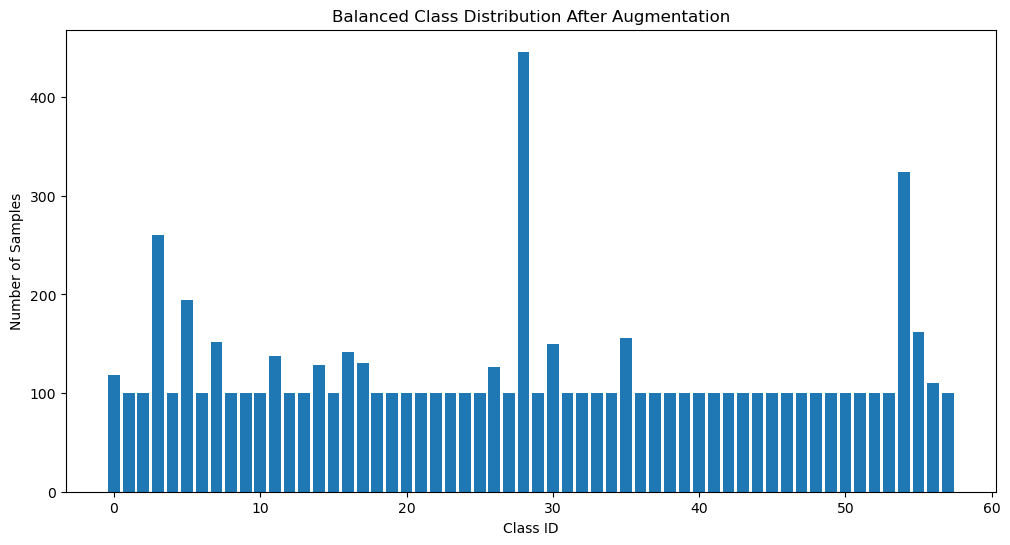


--- Multi-class Baseline Accuracy ---
Number of Classes: 58
Multi-class Random Baseline Accuracy: 0.021

--- Baseline KNN Model Performance ---
Baseline KNN Test Accuracy (50/50 split): 0.760
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        66
           1       0.90      0.85      0.87        53
           2       0.77      0.49      0.60        55
           3       0.57      0.68      0.62       142
           4       0.87      0.53      0.66        51
           5       0.36      0.44      0.40        97
           6       0.61      0.50      0.55        40
           7       0.49      0.62      0.55        80
           8       1.00      0.95      0.97        55
           9       1.00      1.00      1.00        45
          10       0.76      0.73      0.74        51
          11       0.88      0.60      0.71        77
          12       1.00      1.00      1.00        49
          13       1.00    

In [91]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Augment Image Function
def augment_image(image):
    transformations = [
        lambda x: cv2.flip(x, 1),
        lambda x: cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE),
        lambda x: cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE),
        lambda x: cv2.GaussianBlur(x, (5, 5), 0),
        lambda x: x + np.random.normal(0, 5, x.shape).astype(np.uint8)
    ]
    return random.choice(transformations)(image)

# paths
data_path = '/Users/fatima..../Documents/GitHub/Intro-AI-Coursework/data/traffic_Data/DATA'

# Data Augmentation
images_augmented, class_ids_augmented = [], []
min_samples = 100

for class_id in range(58):  # Iterate through all 58 classes
    directory = os.path.join(data_path, str(class_id))
    if os.path.exists(directory):
        img_files = os.listdir(directory)
        img_count = 0

        for img_file in img_files:
            img_path = os.path.join(directory, img_file)
            image = cv2.imread(img_path)

            if image is not None:
                image = cv2.resize(image, (32, 32))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                images_augmented.append(image.flatten())
                class_ids_augmented.append(class_id)
                img_count += 1

        # Augment if the class has fewer than min_samples
        if img_count < min_samples:
            for _ in range(min_samples - img_count):
                if image is not None:
                    augmented_image = augment_image(image)
                    images_augmented.append(augmented_image.flatten())
                    class_ids_augmented.append(class_id)

# Verify Augmented Dataset Distribution ---
class_distribution = Counter(class_ids_augmented)
print("Class distribution after augmentation:", class_distribution)

# Plot Balanced Class Distribution
plt.figure(figsize=(12, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Balanced Class Distribution After Augmentation')
plt.show()

# Multi-class Random Baseline Accuracy
num_classes = len(class_distribution)  # Total number of classes
class_probabilities = [count / sum(class_distribution.values()) for count in class_distribution.values()]
random_baseline_accuracy = sum([p**2 for p in class_probabilities])

print(f"\n--- Multi-class Baseline Accuracy ---")
print(f"Number of Classes: {num_classes}")
print(f"Multi-class Random Baseline Accuracy: {random_baseline_accuracy:.3f}")

# Prepare Data for Baseline Model
X = np.array(images_augmented)
y = np.array(class_ids_augmented)

# Standardize the Dataset
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Split Data into Training and Test Sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.5, random_state=42)

# Baseline KNN Model
print("\n--- Baseline KNN Model Performance ---")
baseline_knn = KNeighborsClassifier(n_neighbors=5)
baseline_knn.fit(X_train, y_train)

# Evaluate Baseline Model
y_pred = baseline_knn.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline KNN Test Accuracy (50/50 split): {baseline_accuracy:.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


#Hyperparameter Tuning with GridSearchCV
print("\n--- Hyperparameter Tuning Using GridSearchCV ---")
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
optimized_knn = grid_search.best_estimator_

# Evaluate Optimized Model
y_pred_optimized = optimized_knn.predict(X_test)
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized KNN Test Accuracy: {optimized_accuracy:.3f}")
print("Classification Report (Optimized):")
print(classification_report(y_test, y_pred_optimized, zero_division=0))

#  Compare Results
print("\n--- Comparison of Baseline and Optimized Model ---")
print(f"Random Baseline Accuracy: {random_baseline_accuracy:.3f}")
print(f"Baseline KNN Accuracy: {baseline_accuracy:.3f}")
print(f"Optimized KNN Accuracy: {optimized_accuracy:.3f}")
print(f"Improvement over Baseline KNN: {(optimized_accuracy - baseline_accuracy):.3f}")
print(f"Improvement over Random Baseline: {(optimized_accuracy - random_baseline_accuracy):.3f}")
